In [1]:
# Importing required libraries
# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

In [2]:
# Defining helper functions.
def find_most_common_solutions(input_dict, n):
    """
    Sorts the keys of the input dictionary in descending order based on their values and returns the first n keys.

    Arguments:
        input_dict (dict): A dictionary containing the keys and their corresponding values.
        n (int): The number of most common solutions to return.

    Returns:
        list: A list of the n most common keys sorted in descending order based on their values.
    """
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
def build_qubo(arr: list):
    """
    Function to build a QUBO (Quadratic Unconstrained Binary Optimization) model from a given array
    for the Number Partitioning Problem (NPP).

    Arguments:
        arr (list): a list of integers representing the array from which the QUBO model is built

    Returns:
        tuple: containing the quadratic coefficients, linear coefficients, and the QUBO model
    """

    # Length of the array - Length of the binary vector x
    n = len(arr)
    # Sum of the array - c
    c = sum(arr)

    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    # Cost Function for Number Partitioning Problem (NPP)
    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    
    model.minimize(Q)   
    problem = from_docplex_mp(model)

    # QUBO formulation
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)

    # Quadratic and Linear Coefficients
    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo


# Function to print solutions for NPP.
def print_solution(counts):
    
    # Printing Solutions Sets.
    best_sol = find_most_common_solutions(counts,3)
    print(f'Top 3 solutions for the array {test_array} and {layers} layer(s): \n{best_sol}')

    # Calculating S and S_A
    S = []
    S_A = []
    for ind,bit in enumerate(best_sol[0]):
        if bit == '1':
            S.append(ind)
        else:
            S_A.append(ind)

    # Calculating Sum(S) and Sum(S/A)
    sum_S = sum(np.array(test_array)[S])
    sum_S_A = sum(np.array(test_array)[S_A])

    # Printing the best optimal partition.
    print(f'\nBest Partition:\nS: {np.array(test_array)[S]}\nSum(S) = {sum_S}\n\nS/A: {np.array(test_array)[S_A]}\nSum(S/A) = {sum_S_A}')
    return None



In [3]:
def apply_cost_unitary(circuit, num_qubits, gamma, quadratics, linears):
    """
    Applies the cost unitary operation for the QAOA algorithm.

    Args:
        circuit (QuantumCircuit): The quantum circuit.
        num_qubits (int): The number of qubits.
        gamma (float): The gamma parameter for the cost unitary.
        quadratics (numpy.ndarray): Quadratic coefficients for the QUBO problem.
        linears (numpy.ndarray): Linear coefficients for the QUBO problem.
    """
    for i in range(num_qubits):
        # Calculate quad_sum as a scalar
        quad_sum = sum(quadratics[i * num_qubits + j] for j in range(num_qubits))
        sum_linears = sum(linears[j] for j in range(num_qubits))
        # Apply Rz gate with a scalar parameter
        circuit.rz(0.5 * ((sum_linears) + quad_sum) * gamma, i)

    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            # Apply Rzz gate with a scalar parameter
            circuit.rzz(0.25 * quadratics[i * num_qubits + j] * gamma, i, j)


def apply_mixer_unitary(circuit, num_qubits, beta):
    # Apply mixer Hamiltonian operations here
    for i in range(num_qubits):
        circuit.rx(2.0 * beta, i)



def design_circuit(num_qubits, gammas, betas, quadratics, linears, shots=500):
    # Create a quantum circuit
    qaoa_circuit = QuantumCircuit(num_qubits, num_qubits)

    # Apply Hadamard gates to initialize qubits in |+⟩ state
    for i in range(num_qubits):
        qaoa_circuit.h(i)
    
    # Apply QAOA layers
    for layer in range(len(gammas)):
        # Apply cost Hamiltonian
        apply_cost_unitary(qaoa_circuit, num_qubits, gammas[layer], quadratics, linears)
        
        # Apply mixer Hamiltonian
        apply_mixer_unitary(qaoa_circuit, num_qubits, betas[layer])
    
    # Measure the qubits
    qaoa_circuit.measure(range(num_qubits), range(num_qubits))
    
    # Execute the circuit and obtain the measurement result
    simulator = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qaoa_circuit, simulator)
    
    job = simulator.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
 
    return counts


Function call: 1 - Cost: 5.16
Function call: 2 - Cost: 4.024
Function call: 3 - Cost: 5.576
Function call: 4 - Cost: 5.42
Function call: 5 - Cost: 4.336
Function call: 6 - Cost: 4.504
Function call: 7 - Cost: 4.612
Function call: 8 - Cost: 5.9
Function call: 9 - Cost: 4.98
Function call: 10 - Cost: 5.16
Function call: 11 - Cost: 4.92
Function call: 12 - Cost: 5.192
Function call: 13 - Cost: 4.848
Function call: 14 - Cost: 4.584
Function call: 15 - Cost: 3.944
Function call: 16 - Cost: 3.908
Function call: 17 - Cost: 5.564
Function call: 18 - Cost: 3.676
Function call: 19 - Cost: 5.268
Function call: 20 - Cost: 4.608
Function call: 21 - Cost: 5.484
Function call: 22 - Cost: 4.652
Function call: 23 - Cost: 2.876
Function call: 24 - Cost: 4.44
Function call: 25 - Cost: 2.996
Function call: 26 - Cost: 3.684
Function call: 27 - Cost: 4.272
Function call: 28 - Cost: 2.984
Function call: 29 - Cost: 3.744
Function call: 30 - Cost: 2.824
Function call: 31 - Cost: 2.964
Function call: 32 - Cost:

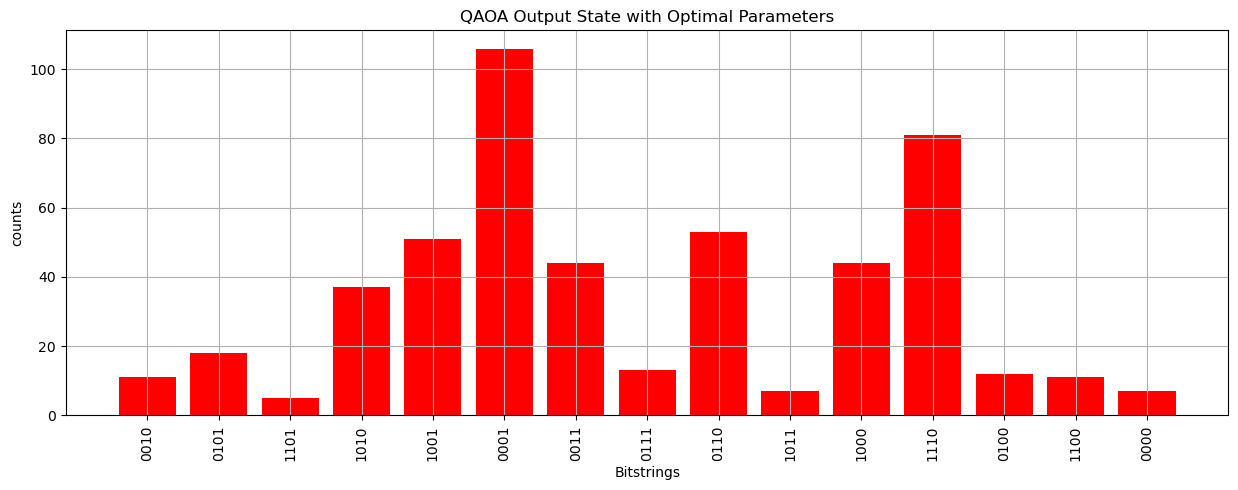

In [27]:
# Global variables for function calls and tracking cost.
func_call = 0
theta = []
cost = []


# Callback function
def callback_func(x):
    theta.append(x)
    return None

# QAOA Function for the Number Partitioning Problem
def qaoa_NPP(arr,layers:int):
    """
    Function implementing the QAOA algorithm for the Number Partitioning Problem.

    Args:
        arr (list): a list of integers.
        layers (int): the number of layers in the QAOA circuit.
    Returns:
        counts (dict): a dictionary containing the counts of each bitstring.

    """
    # Building the QUBO for NPP
    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    # Preparing the coefficients as flattened numpy arrays
    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray().flatten()

    
    def npp_obj(bit_string, arr):
        """Calculate the objective value for a given bit string for NPP.
        
        Args:
            bit_string (str): Bit string representing the partition.
            arr (list): List of integers representing the numbers to be partitioned.
            
        Returns:
            float: Objective value (absolute difference between sums of partitions).
        """
        sum_0 = 0
        sum_1 = 0
        for i in range(len(bit_string)):
            if bit_string[i] == '0':
                sum_0 += arr[i]
            else:
                sum_1 += arr[i]
        return abs(sum_0 - sum_1)
    
    # Objective function we want to optimize
    def expectation_value(theta):
        """
        Computes the expectation value for the given theta parameters.
    
        Args:
            theta (numpy.ndarray): Array of gamma and beta parameters.
    
        Returns:
            float: The expectation value.
            
        """
        global func_call 
        func_call += 1
    
        middle = int(len(theta) / 2)
        gammas = theta[:middle]
        betas = theta[middle:]
    
        counts = design_circuit(num_qubits, gammas, betas, quadratics, linears, shots=500)

        #convert results to a standard python dict
        dict_results = dict(counts)

        avg = 0
        sum_count = 0
        for bit_string, count in counts.items():
            obj = npp_obj(bit_string, arr)
            avg += obj * count
            sum_count += count
            
        exp = avg/sum_count
        # best_sol = max(dict_results, key=dict_results.get)

        # exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        
    
    
        cost.append(exp)
    
        print(f'Function call: {func_call} - Cost: {exp}')
    
        return exp




    
    
    # Initial guess for gammas and betas
    # init_gamma = np.array([pi / 3] * layers)
    # init_beta = np.array([pi / 4] * layers)
    # initial_guess = np.concatenate((init_gamma, init_beta))
    initial_guess = [1,1,1,1]
    # Minimization of the objective function. We are using the COBYLA optimizer.
    start_time = time.time()
    # COBYLA #L-BFGS-B, Powell different optimizers
    res = minimize(expectation_value, initial_guess, method='cobyla',callback=callback_func)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # print(f'\nElapsed time for QAOA: {elapsed_time} seconds')

    # Preparing the final gammas and betas
    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    # Printing the optimal parameters
    # print(f'Gammas: {prime_gammas}\nBetas: {prime_betas}\nFinal Cost: {res.fun}\n')

   
    # Calling the QAOA function with optimal gammas and betas
    final_results = design_circuit(num_qubits, prime_gammas, prime_betas, quadratics, linears, shots=500)
    # # print("this is final results", final_results)
    

    
    return final_results

# Defining a test array
test_array = [2,1,3,5]
layers = 6

# Running QAOA on for Number Partitioning.
split_results = qaoa_NPP(test_array,layers)


print_solution(split_results)

# Plotting the optimal output state.
plt.figure(figsize=(15, 5))
plt.bar(range(len(split_results)), list(split_results.values()), align='center', color='red')
plt.xticks(range(len(split_results)), list(split_results.keys()), rotation=90)
plt.title("QAOA Output State with Optimal Parameters")
plt.xlabel("Bitstrings")
plt.ylabel("counts")
plt.grid()
plt.show()

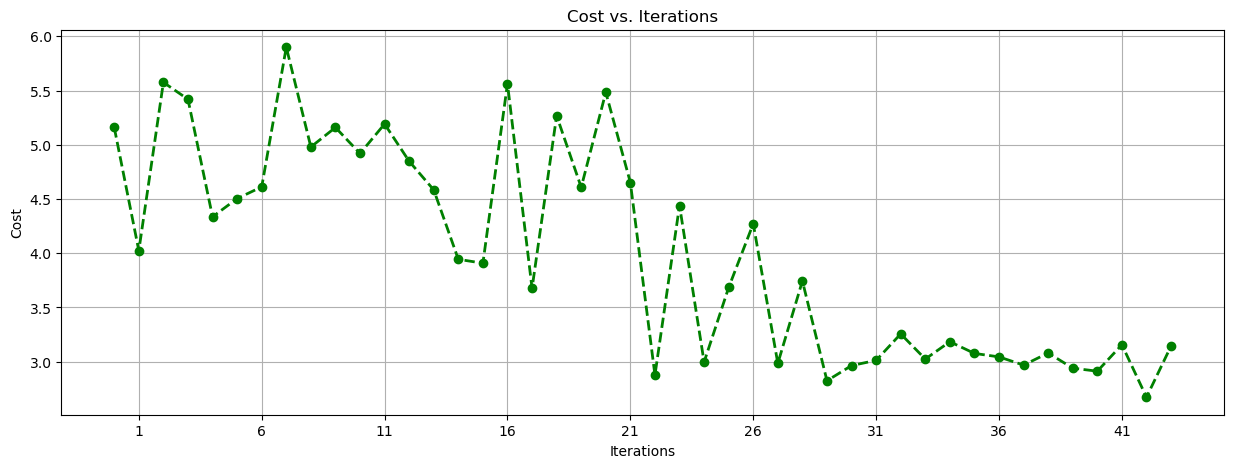

In [28]:
# Plotting Cost vs Iterations.
plt.figure(figsize=(15, 5))
plt.plot(range(len(cost)),cost,color='g',ls='--',marker='o',lw=2)
plt.xticks(range(1,len(cost)+1,5))
plt.title('Cost vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid()
plt.show()